### https://www.census.gov/data/developers/data-sets.html

In [1]:
import pandas as pd
import numpy as np
import pandas as pd
import numpy as np
import os
from urllib.request import urlopen
import json
import requests
import seaborn as sns

path=os.getcwd()

In [2]:
bse='S0101_C01_001E' #"Estimate!!Total!!Total population"
gp=['state','zip code tabulation area']

### Get data

In [11]:
kmeans_variables=pd.read_csv(path+'/kmeans_variables2.csv')
kmeans_variables[:1]

,Category,Name,Label,Concept,Required,Attributes,Limit,Predicate Type,Group,purpose
0,Cultural,S0102_C01_061E,"Estimate!!Total!!PLACE OF BIRTH, NATIVITY AND ...",POPULATION 60 YEARS AND OVER IN THE UNITED STATES,not required,"S0102_C01_061EA, S0102_C01_061M, S0102_C01_061MA",0,float,S0102,NaN


In [12]:
raw=pd.read_csv(path+'/01_raw.csv')
raw[:3]

,S0101_C01_001E,S0102_C01_061E,S0102_C01_065E,S1601_C01_004E,S1601_C01_012E,S0101_C03_001E,S0101_C03_002E,S0101_C03_003E,S0101_C03_004E,S0101_C03_005E,...,S0101_C05_010E,S0101_C05_011E,S0101_C05_012E,S0101_C05_013E,S0101_C05_014E,S0101_C05_015E,S0101_C05_016E,S0101_C05_017E,S0101_C05_018E,S0101_C05_019E
0,600,NaN,NaN,0,0,282,0,0,20,0,...,0,20,34,20,0,71,35,0,40,0
1,964,NaN,NaN,0,0,473,54,19,0,0,...,20,9,32,36,43,25,69,60,27,0
2,1700,NaN,NaN,0,0,918,9,15,173,77,...,76,62,76,41,15,66,38,8,34,0


## EDA

In [13]:
dt=pd.DataFrame(raw.dtypes,columns=['Data_Type'])
dt['Column']=dt.index
dt['Data_Type']=dt['Data_Type'].astype(str)
dt=dt.sort_values('Column')
print(dt['Data_Type'].unique())

['int64' 'float64']


In [14]:
n_cols=list(dt[(dt['Data_Type']=='int64')]['Column'])
n_cols=n_cols+list(dt[(dt['Data_Type']=='float64')]['Column'])

cols=[]
for col in n_cols:
    cols.append([col, raw[col].min(), raw[col].max()])
cols=pd.DataFrame(cols,columns=['Column','min','max'])
cols

,Column,min,max
0,S0101_C01_001E,0.0,128294.0
1,S0101_C03_001E,0.0,61291.0
2,S0101_C03_002E,0.0,8819.0
3,S0101_C03_003E,0.0,7819.0
4,S0101_C03_004E,0.0,6153.0
...,...,...,...
104,S2406_C06_001E,-666666666.0,100.0
105,S2902_C01_012E,NaN,NaN
106,S2902_C01_013E,NaN,NaN
107,S2902_C01_014E,NaN,NaN


##### take out null only and negative only columns

In [15]:
cols[(cols['min'].isna()) & (cols['max'].isna())]

,Column,min,max
105,S2902_C01_012E,NaN,NaN
106,S2902_C01_013E,NaN,NaN
107,S2902_C01_014E,NaN,NaN
108,S2902_C01_015E,NaN,NaN


In [7]:
# take out null only columns
for idx, row in cols[(cols['min'].isna()) & (cols['max'].isna())].iterrows():
    c=row['Column']
    raw=raw.drop(c,1)
    cols=cols[cols['Column']!=c]
raw.shape

(33120, 105)

In [8]:
# take out null only columns
for idx, row in cols[(cols['min']<=0) & (cols['max']<=0)].iterrows():
    c=row['Column']
    raw=raw.drop(c,1)
    cols=cols[cols['Column']!=c]
raw.shape

(33120, 105)

In [9]:
cols[(cols['min']<0)]

,Column,min,max
99,S0601_C01_030E,-666666666.0,100.0
101,S0601_C01_047E,-666666666.0,250000.0
102,S1201_C02_001E,-666666666.0,100.0
103,S2406_C03_001E,-666666666.0,100.0
104,S2406_C06_001E,-666666666.0,100.0


### what to do with negative and null values in other variables?

for idx, row in cols[(cols['min']<0)].iterrows():
    c=row['Column']
    sns.displot(raw[raw[c]>=0], x=c, bins=20,height=3, aspect=11.7/8.27)

In [10]:
rd=raw.describe()
rd=rd.T
rd=rd.reset_index()
rd=rd.rename(columns={'index':'Name'})

In [11]:
total=list(rd[rd['Name']=='state']['count'])[0]
total

33120.0

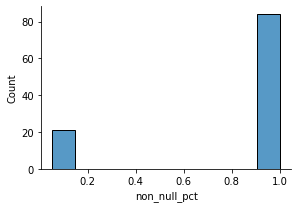

In [12]:
rd['non_null_pct']=rd['count']/total
sns.displot(rd, x='non_null_pct', bins=10,height=3, aspect=11.7/8.27)

In [13]:
smry=[]
for c in [x for x in list(raw.columns) if x not in gp]:
    TF=(raw[c].isnull()) | (raw[c]<0)
    non_null_ct=raw[TF].shape[0]
    mn=raw[~TF][c].min()
    mx=raw[~TF][c].max()
    md=raw[~TF][c].median()
    rtio=raw[~TF][c]/raw[~TF][bse]
    gt1pct=sum(rtio>1)/total
    rtio=rtio.max()
    smry.append([c,non_null_ct,mn,md,mx,rtio,gt1pct])

In [14]:
smry=pd.DataFrame(smry, columns=['Name','Null_CT','min','max','median','PerPerson','gt1pct'])
smry

,Name,Null_CT,min,max,median,PerPerson,gt1pct
0,S0101_C01_001E,0,0.0,2801.0,128294.0,1.000000,0.0
1,S0102_C01_061E,30214,9.3,46.0,89.8,0.004846,0.0
2,S0102_C01_065E,30214,0.2,5.4,69.2,0.001952,0.0
3,S1601_C01_004E,0,0.0,48.0,89935.0,1.000000,0.0
4,S1601_C01_012E,0,0.0,3.0,47655.0,0.666667,0.0
...,...,...,...,...,...,...,...
98,S0101_C05_015E,0,0.0,87.0,6503.0,1.000000,0.0
99,S0101_C05_016E,0,0.0,67.0,8331.0,1.000000,0.0
100,S0101_C05_017E,0,0.0,47.0,5107.0,1.000000,0.0
101,S0101_C05_018E,0,0.0,32.0,2770.0,1.000000,0.0


#### per person value>1

In [15]:
g1=smry[smry['PerPerson']>1]
g1

,Name,Null_CT,min,max,median,PerPerson,gt1pct
34,S0102_C01_076E,30214,36568.0,84663.5,319623.0,28.667531,0.082699
35,S0601_C01_047E,1462,2499.0,29210.5,250000.0,12625.000000,0.858364
40,S2406_C06_001E,591,0.0,6.3,100.0,25.000000,0.003231
41,S2406_C03_001E,591,0.0,2.9,100.0,14.285714,0.001570
76,S1201_C02_001E,345,0.0,53.4,100.0,33.333333,0.016002
82,S0601_C01_030E,474,0.0,12.6,100.0,100.000000,0.004016


In [16]:
kmeans_variables.merge(g1[['Name','PerPerson','gt1pct']],how='inner',on='Name')

,Category,Name,Label,Concept,Required,Attributes,Limit,Predicate Type,Group,purpose,PerPerson,gt1pct
0,Economics,S0102_C01_076E,Estimate!!Total!!INCOME IN THE PAST 12 MONTHS ...,POPULATION 60 YEARS AND OVER IN THE UNITED STATES,not required,"S0102_C01_076EA, S0102_C01_076M, S0102_C01_076MA",0,int,S0102,NaN,28.667531,0.082699
1,Economics,S0601_C01_047E,Estimate!!Total!!INDIVIDUALS' INCOME IN THE PA...,SELECTED CHARACTERISTICS OF THE TOTAL AND NATI...,not required,"S0601_C01_047EA, S0601_C01_047M, S0601_C01_047MA",0,int,S0601,NaN,12625.000000,0.858364
2,Employment,S2406_C06_001E,Estimate!!Self-employed in own not incorporate...,OCCUPATION BY CLASS OF WORKER FOR THE CIVILIAN...,not required,"S2406_C06_001EA, S2406_C06_001M, S2406_C06_001MA",0,float,S2406,NaN,25.000000,0.003231
3,Employment,S2406_C03_001E,Estimate!!Self-employed in own incorporated bu...,OCCUPATION BY CLASS OF WORKER FOR THE CIVILIAN...,not required,"S2406_C03_001EA, S2406_C03_001M, S2406_C03_001MA",0,float,S2406,NaN,14.285714,0.001570
4,Family Status,S1201_C02_001E,Estimate!!Now married (except separated)!!Popu...,MARITAL STATUS,not required,"S1201_C02_001EA, S1201_C02_001M, S1201_C02_001MA",0,float,S1201,NaN,33.333333,0.016002
5,Marital Status,S0601_C01_030E,Estimate!!Total!!MARITAL STATUS!!Population 15...,SELECTED CHARACTERISTICS OF THE TOTAL AND NATI...,not required,"S0601_C01_030EA, S0601_C01_030M, S0601_C01_030MA",0,float,S0601,NaN,100.000000,0.004016


In [17]:
# two variables that are incomes are already at per person/HH level, shall not divide by pop
g1=g1[g1['gt1pct']>.02]
g1

,Name,Null_CT,min,max,median,PerPerson,gt1pct
34,S0102_C01_076E,30214,36568.0,84663.5,319623.0,28.667531,0.082699
35,S0601_C01_047E,1462,2499.0,29210.5,250000.0,12625.000000,0.858364


In [18]:
# missing values that needs to be imputed
for c in list(g1['Name']):
    TF=(raw[c].isnull()) | (raw[c]<0)
    raw.loc[TF,c]=np.nan

#### Null_CT>0

In [19]:
g2=smry[smry['Null_CT']>0]
g2['Null_Pct']=g2['Null_CT']/total
g2=g2[~g2['Name'].isin(g1['Name'])]
g2

<ipython-input-19-b41264f7e916>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  g2['Null_Pct']=g2['Null_CT']/total


,Name,Null_CT,min,max,median,PerPerson,gt1pct,Null_Pct
1,S0102_C01_061E,30214,9.3,46.00,89.8,0.004846,0.000000,0.912258
2,S0102_C01_065E,30214,0.2,5.40,69.2,0.001952,0.000000,0.912258
24,S0502_C01_022E,31365,22.6,45.10,61.1,0.003797,0.000000,0.947011
25,S0502_C01_023E,31365,59.7,98.20,100.0,0.007522,0.000000,0.947011
26,S0502_C01_024E,31365,0.5,41.00,96.7,0.006895,0.000000,0.947011
27,S0502_C01_025E,31365,0.0,3.30,94.3,0.004551,0.000000,0.947011
28,S0502_C01_026E,31365,0.0,0.20,12.4,0.000380,0.000000,0.947011
29,S0502_C01_027E,31365,0.0,22.30,92.6,0.006275,0.000000,0.947011
30,S0502_C01_028E,31365,0.0,0.00,22.7,0.000399,0.000000,0.947011
31,S0502_C01_029E,31365,0.0,10.80,73.3,0.003650,0.000000,0.947011


In [20]:
### those variables we need impute nulls; also need compute per person
for c in list(g2['Name']):
    TF=(raw[c].isnull()) | (raw[c]<0)
    raw.loc[TF,c]=np.nan
    raw[c]=raw[c]/raw[bse]
    TF=raw[c]>1
    raw.loc[TF,c]=1

#### variables with all good value

In [22]:
g3=smry[~((smry['Name'].isin(g1['Name'])) | (smry['Name'].isin(g2['Name'])))]
g3=g3[g3['Name']!=bse]

In [23]:
print(g1.shape) # don't divide by population
print(g2.shape)
print(g3.shape)

(2, 7)
(25, 8)
(75, 7)


In [24]:
# QA
75+25+2==raw.shape[1]-len([bse])-len(gp)

True

In [25]:
### those variables need scompute per person
for c in list(g3['Name']):
    raw[c]=raw[c]/raw[bse]
    TF=raw[c]>1
    raw.loc[TF,c]=1

In [26]:
raw[[bse,'S1601_C01_004E','S1601_C01_012E']][raw['S1601_C01_012E']>0][:3]

,S0101_C01_001E,S1601_C01_004E,S1601_C01_012E
3,6764,0.008427,0.014784
4,10964,0.007114,0.004469
5,11062,0.011481,0.012475


### EDA

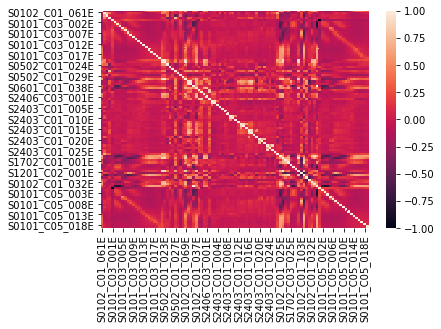

In [27]:
num_cols=[x for x in list(raw.columns) if x not in gp+[bse]]
corr=raw[num_cols].corr()
pl=sns.heatmap(corr)

In [28]:
corr.to_csv(path+'/02_corr.csv')

In [29]:
raw.to_csv(path+'/02_raw.csv',index=False)